In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Quoc Trung Ho <hoquoctrung98@gmail.com>
"""

import sys
from typing import Any, Callable, Iterable, List, Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("../")  # add the qball package to the python path
# sys.path.append(os.path.realpath('..'))

from bubble_gw import many_bubbles

In [2]:
%matplotlib ipympl
sns.set(style="ticks", font="Dejavu Sans")
sns.set_palette("bright")
# set default font for both text and mathtext
mpl.rcParams["mathtext.default"] = "regular"
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
# mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(
    {
        "axes.linewidth": 1,
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{bm} \usepackage{xcolor}",
        # Enforce default LaTeX font.
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "font.weight": "bold",
        "figure.facecolor": "white",
        "animation.html": "jshtml",
    }
)

# do not show figures on screen
plt.ioff()

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

In [3]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


class BubbleCollision:
    def __init__(self, bulk_flow: many_bubbles.BulkFlow):
        self.bulk_flow = bulk_flow
        self.a_idx = None
        self.first_bubble = None
        self.delta_tab_grid = None

    def set_reference_bubble_index(self, a_idx):
        """
        Set the reference bubble index and compute first_bubble and delta_tab_grid.

        Parameters:
        - a_idx: Index of the reference bubble
        """
        self.a_idx = a_idx
        self.first_bubble = self.bulk_flow.compute_first_colliding_bubble(a_idx=a_idx)
        self.delta_tab_grid = self.bulk_flow.compute_delta_tab(
            a_idx=a_idx, first_bubble=self.first_bubble
        )

    def get_collision_info(self, phi, cos_theta):
        """
        Get collision information for the grid point closest to (phi, cos_theta).

        Parameters:
        - phi: Target phi value (0 to 2*pi)
        - cos_theta: Target cos(theta) value (-1 to 1)

        Returns:
        - dict: Dictionary with keys 'phi', 'cos_theta', 'first_bubble_index', 'collision_time'
                containing the closest grid point values and corresponding data.
        """
        if self.first_bubble is None or self.delta_tab_grid is None:
            raise ValueError(
                "Reference bubble index not set. Call set_reference_bubble_index first."
            )

        # Define grid arrays
        cos_theta_arr = self.bulk_flow.cos_thetax
        phi_arr = self.bulk_flow.phix

        # Find closest indices
        phi_idx = np.argmin(np.abs(phi_arr - phi))
        cos_theta_idx = np.argmin(np.abs(cos_theta_arr - cos_theta))

        # Get values at closest indices
        phi_val = phi_arr[phi_idx]
        cos_theta_val = cos_theta_arr[cos_theta_idx]
        first_bubble_index = self.first_bubble[cos_theta_idx, phi_idx]
        collision_time = self.delta_tab_grid[cos_theta_idx, phi_idx]

        return {
            "phi": phi_val,
            "cos_theta": cos_theta_val,
            "first_bubble_index": first_bubble_index,
            "collision_time": collision_time,
        }

    def plot_first_collision_indices(self, fig, ax):
        """
        Plot the indices of the first colliding bubble for each point on the reference bubble.
        Uses black for -1 (never collide), Set1 colors for first 8 interior/exterior indices,
        and tab10 colors for additional indices.
        Only shows major tick in the middle of each color band (no boundary/minor ticks).
        """
        if self.first_bubble is None or self.a_idx is None:
            raise ValueError(
                "Reference bubble index not set. Call set_reference_bubble_index first."
            )

        # Get unique integer values in first_bubble
        unique_values = np.unique(self.first_bubble)

        # Separate never-collide (-1) and other indices
        has_never_collide = -1 in unique_values
        remaining_values = [val for val in unique_values if val != -1]

        # Build color list
        colors = []
        if has_never_collide:
            colors.append("#000000")  # black for never collide

        # Use Set1 for first 8 indices, tab10 for rest (your preferred scheme)
        for i in range(len(remaining_values)):
            if i < 8:  # Set1 has 8 distinct colors
                colors.append(plt.cm.Set1(i))
            else:
                # For additional values, use tab10
                colors.append(plt.cm.tab10((i - 8) % 10))

        # Create discrete colormap
        cmap = mcolors.ListedColormap(colors)

        # Define boundaries → ensure integer spacing for exact mapping
        boundaries = np.arange(len(unique_values) + 1) - 0.5
        norm = mcolors.BoundaryNorm(boundaries, cmap.N)

        # Define tick locations *only* at the center of each bin (no boundary ticks)
        tick_locations = np.arange(len(unique_values))

        # Build labels in the same order as colors/unique_values
        ordered_values = (
            [-1] + remaining_values if has_never_collide else remaining_values
        )
        labels = []
        for val in ordered_values:
            if val == -1:
                labels.append("Never Collide")
            elif val >= 0:
                labels.append(f"Interior {val}")
            else:  # val <= -2
                exterior_idx = -(val + 2)
                labels.append(f"Exterior {exterior_idx}")

        # Remap data to sequential integer indices for correct colormap indexing
        mapping = {val: idx for idx, val in enumerate(ordered_values)}
        first_bubble_mapped = np.vectorize(mapping.get)(self.first_bubble)

        # Create the plot
        im = ax.imshow(
            first_bubble_mapped,
            extent=[0, 2 * np.pi, 1, -1],
            cmap=cmap,
            norm=norm,
            aspect="auto",
        )
        ax.invert_yaxis()

        # Colorbar: only show major ticks at bin centers, disable minor ticks
        cbar = fig.colorbar(im, ax=ax, ticks=tick_locations)
        cbar.set_label("Bubble Indices")
        cbar.set_ticklabels(labels)

        cbar.ax.minorticks_off()  # This removes the small ticks at bin boundaries

        # Axis formatting
        phix_ticks = np.arange(0, 2 * np.pi + 0.01, np.pi / 4)
        phix_labels = [
            "0",
            r"$\pi/4$",
            r"$\pi/2$",
            r"$3\pi/4$",
            r"$\pi$",
            r"$5\pi/4$",
            r"$3\pi/2$",
            r"$7\pi/4$",
            r"$2\pi$",
        ]
        ax.set_xticks(phix_ticks)
        ax.set_xticklabels(phix_labels)
        costhetax_ticks = np.arange(-1, 1.1, 0.25)
        ax.set_yticks(costhetax_ticks)

        ax.set_xlabel(r"$\phi$")
        ax.set_ylabel(r"$\cos \theta$")
        ax.set_title(
            f"Index of the bubble that has the first collision to a point on bubble {self.a_idx}"
        )

    def plot_collision_time(self, fig, ax, vmin=0, vmax=None, cmap="inferno"):
        """
        Plot the collision time (delta_tab_grid) for points on the reference bubble.

        Parameters:
        - vmin: Minimum value for colormap (default: 0)
        - vmax: Maximum value for colormap (default: 10)
        - cmap: Colormap name (default: 'inferno')
        """
        if self.delta_tab_grid is None or self.a_idx is None:
            raise ValueError(
                "Reference bubble index not set. Call set_reference_bubble_index first."
            )
        if vmax is None:
            vmax = np.max(self.delta_tab_grid)

        # Create the plot
        im = ax.imshow(
            self.delta_tab_grid,
            extent=[0, 2 * np.pi, 1, -1],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            aspect="auto",
        )
        ax.invert_yaxis()
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Collision Time")

        phix_ticks = np.arange(0, 2 * np.pi + 0.01, np.pi / 4)
        phix_labels = [
            "0",
            r"$\pi/4$",
            r"$\pi/2$",
            r"$3\pi/4$",
            r"$\pi$",
            r"$5\pi/4$",
            r"$3\pi/2$",
            r"$7\pi/4$",
            r"$2\pi$",
        ]
        ax.set_xticks(phix_ticks)
        ax.set_xticklabels(phix_labels)
        costhetax_ticks = np.arange(-1, 1.1, 0.25)
        ax.set_yticks(costhetax_ticks)

        ax.set_xlabel(r"$\phi$")
        ax.set_ylabel(r"$\cos \theta$")
        ax.set_title(rf"Collision time $\Delta t$ of points on bubble {self.a_idx}")

    def plot_collision_status(
        self, fig, ax, t=7, colors=["#000000", "#37ff00", "#ff3025"]
    ):
        """
        Plot the collision status at time t for points on the reference bubble.

        Parameters:
        - t: Time at which to compute collision status (default: 7)
        - colors: List of colors for values 0, 1, 2 (default: black, green, red)

        Returns:
        - fig, ax: Matplotlib figure and axes objects
        """
        if (
            self.first_bubble is None
            or self.delta_tab_grid is None
            or self.a_idx is None
        ):
            raise ValueError(
                "Reference bubble index not set. Call set_reference_bubble_index first."
            )

        # Compute collision status
        collision_status = self.bulk_flow.compute_collision_status(
            a_idx=self.a_idx,
            t=t,
            first_bubble=self.first_bubble,
            delta_tab_grid=self.delta_tab_grid,
        )

        # Define a discrete colormap
        cmap = mcolors.ListedColormap(colors)
        boundaries = [-0.5, 0.5, 1.5, 2.5]
        norm = mcolors.BoundaryNorm(boundaries, cmap.N)

        # Create the plot
        im = ax.imshow(
            collision_status,
            extent=[0, 2 * np.pi, 1, -1],
            cmap=cmap,
            norm=norm,
            aspect="auto",
        )
        ax.invert_yaxis()
        cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2])
        cbar.set_ticklabels(["Never Collide", "Already Collided", "Not Yet Collided"])
        # cbar.set_label("Collision Status")

        phix_ticks = np.arange(0, 2 * np.pi + 0.01, np.pi / 4)
        phix_labels = [
            "0",
            r"$\pi/4$",
            r"$\pi/2$",
            r"$3\pi/4$",
            r"$\pi$",
            r"$5\pi/4$",
            r"$3\pi/2$",
            r"$7\pi/4$",
            r"$2\pi$",
        ]
        ax.set_xticks(phix_ticks)
        ax.set_xticklabels(phix_labels)
        costhetax_ticks = np.arange(-1, 1.1, 0.25)
        ax.set_yticks(costhetax_ticks)

        ax.set_xlabel(r"$\phi$")
        ax.set_ylabel(r"$\cos \theta$")
        ax.set_title(
            f"Collision status of points on bubble Interior({self.a_idx}) at t={t}"
        )

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps
from scipy.stats import linregress


def plot_omega_gw(
    fig,
    ax,
    w_arr,
    C_arr,
    ir_range,
    uv_range,
    coefficients_sets=None,
    powers_sets=None,
    colormap="viridis",
):
    """
    Plot the gravitational wave spectrum Omega_GW and fit power-law models in specified IR and UV frequency ranges
    for multiple sets of coefficients and powers, with labels showing coefficients and powers or 'Envelope Approximation'.
    Envelope Approximation uses black color, others use specified colormap (continuous or qualitative).

    Parameters:
    -----------
    w_arr : np.ndarray
        1D array of frequencies (positive, sorted in ascending order).
    C_arr : np.ndarray or tuple
        Either a 3D array of shape (2, n_sets, len(w_arr)) where C_arr[0, s, :] is Cplus and C_arr[1, s, :] is Cminus
        for set s, or a 2D array of shape (2, len(w_arr)) for a single set, or a tuple (Cplus, Cminus) where each is a
        1D array of shape (len(w_arr),) for a single set.
    ir_range : tuple
        Tuple (w_ir_min, w_ir_max) specifying the frequency range for IR (low-frequency) power-law fitting.
    uv_range : tuple
        Tuple (w_uv_min, w_uv_max) specifying the frequency range for UV (high-frequency) power-law fitting.
    coefficients_sets : list or np.ndarray, optional
        List or array of coefficient arrays, where coefficients_sets[s] is the array of b_j values for set s.
        If None, default labels are used.
    powers_sets : list or np.ndarray, optional
        List or array of power arrays, where powers_sets[s] is the array of xi_j values for set s.
        If None, default labels are used.
    colormap : str, optional
        Name of the matplotlib colormap to use for non-envelope sets (default: 'viridis').

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The Matplotlib figure object.
    ax : matplotlib.axes.Axes
        The Matplotlib axes object containing the plot.
    """
    # Validate w_arr
    w_arr = np.asarray(w_arr)
    if w_arr.ndim != 1 or np.any(w_arr <= 0):
        raise ValueError("w_arr must be a 1D array of positive frequencies")

    # Handle C_arr input
    if isinstance(C_arr, tuple):
        Cplus, Cminus = C_arr
        if len(Cplus) != len(w_arr) or len(Cminus) != len(w_arr):
            raise ValueError("Cplus and Cminus must have the same length as w_arr")
        C_arr = np.stack([Cplus[np.newaxis, :], Cminus[np.newaxis, :]], axis=0)
    else:
        C_arr = np.asarray(C_arr)
        if C_arr.ndim == 2:
            if C_arr.shape[0] != 2 or C_arr.shape[1] != len(w_arr):
                raise ValueError("2D C_arr must have shape (2, len(w_arr))")
            C_arr = C_arr[:, np.newaxis, :]
        elif C_arr.ndim == 3:
            if C_arr.shape[0] != 2 or C_arr.shape[2] != len(w_arr):
                raise ValueError("3D C_arr must have shape (2, n_sets, len(w_arr))")
        else:
            raise ValueError("C_arr must be a 2D array, 3D array, or tuple")

    n_sets = C_arr.shape[1]
    n_w = len(w_arr)

    # Validate coefficients_sets and powers_sets and format labels
    if coefficients_sets is not None and powers_sets is not None:
        if len(coefficients_sets) != n_sets or len(powers_sets) != n_sets:
            raise ValueError(
                "coefficients_sets and powers_sets must have length equal to n_sets"
            )
        labels = []
        for s in range(n_sets):
            coeffs = np.asarray(coefficients_sets[s])
            if np.all(coeffs == 0):
                labels.append("Envelope Approximation")
            else:
                # Format coefficients and powers without trailing comma
                coeff_str = ", ".join(f"{c:.2f}" for c in coeffs)
                xi_str = ", ".join(f"{p - 1:.2f}" for p in powers_sets[s])
                labels.append(f"$b_j=({coeff_str}), \\xi_j=({xi_str})$")
    else:
        labels = [
            f"Set {s}" if n_sets > 1 else r"$\Omega_{\text{gw}}$" for s in range(n_sets)
        ]

    # Calculate omega_gw
    omega_gw = np.zeros((n_sets, n_w))
    for s in range(n_sets):
        Cplus = C_arr[0, s, :]
        Cminus = C_arr[1, s, :]
        omega_gw[s, :] = (
            8 * np.pi * w_arr**3 * (np.abs(Cplus) ** 2 + np.abs(Cminus) ** 2)
        )

    # Define colors and linestyles
    # List of known qualitative colormaps
    qualitative_cmaps = [
        "Set1",
        "Set2",
        "Set3",
        "tab10",
        "tab20",
        "tab20b",
        "tab20c",
        "Pastel1",
        "Pastel2",
        "Paired",
        "Accent",
        "Dark2",
    ]
    non_envelope_count = sum(1 for label in labels if label != "Envelope Approximation")

    if non_envelope_count > 0:
        cmap = colormaps[colormap]
        if colormap in qualitative_cmaps:
            # For qualitative colormaps, use the discrete colors and cycle if necessary
            # Access the colormap's colors directly (assuming ListedColormap)
            try:
                # Get the number of colors in the qualitative colormap
                n_colors = len(cmap.colors)
                # Cycle through colors if non_envelope_count > n_colors
                colors_non_envelope = [
                    cmap(i % n_colors) for i in range(non_envelope_count)
                ]
            except AttributeError:
                # Fallback: treat as continuous if colormap doesn't have .colors
                colors_non_envelope = cmap(np.linspace(0, 1, non_envelope_count))
        else:
            # For continuous colormaps, interpolate colors
            colors_non_envelope = cmap(np.linspace(0, 1, non_envelope_count))
    else:
        colors_non_envelope = []

    # Assign colors: black for envelope, colormap colors for others
    color_idx = 0
    colors = []
    for label in labels:
        if label == "Envelope Approximation":
            colors.append("black")
        else:
            colors.append(colors_non_envelope[color_idx])
            color_idx += 1
    linestyles = ["-", "--", ":", "-."] * (n_sets // 4 + 1)

    # Extract IR and UV ranges
    w_ir_min, w_ir_max = ir_range
    if w_ir_min > w_ir_max:
        raise ValueError("ir_range must have w_ir_min <= w_ir_max")
    ir_mask = (w_arr >= w_ir_min) & (w_arr <= w_ir_max)
    w_ir = w_arr[ir_mask]

    w_uv_min, w_uv_max = uv_range
    if w_uv_min > w_uv_max:
        raise ValueError("uv_range must have w_uv_min <= w_uv_max")
    uv_mask = (w_arr >= w_uv_min) & (w_arr <= w_uv_max)
    w_uv = w_arr[uv_mask]

    # Plot omega_gw and fits
    for s in range(n_sets):
        color = colors[s]
        ls = linestyles[s % len(linestyles)]
        label = labels[s]

        # Plot omega_gw
        ax.plot(
            w_arr,
            omega_gw[s, :],
            label=label,
            marker="o",
            ls=ls,
            color=color,
            markersize=4,
            alpha=0.5,
        )

        # IR fitting
        omega_gw_ir = omega_gw[s, ir_mask]
        if len(w_ir) >= 2 and np.all(omega_gw_ir > 0) and np.all(w_ir > 0):
            log_w_ir = np.log10(w_ir)
            log_omega_gw_ir = np.log10(omega_gw_ir)
            slope_ir, intercept_ir, _, _, _ = linregress(log_w_ir, log_omega_gw_ir)
            C0_ir = 10**intercept_ir
            base_ir = slope_ir
            w_fit_ir = np.logspace(np.log10(w_ir[0]), np.log10(w_ir[-1]), 100)
            omega_gw_fit_ir = C0_ir * w_fit_ir**base_ir
            ax.plot(
                w_fit_ir,
                omega_gw_fit_ir,
                ls="--",
                lw=2,
                color=color,
                label=rf"$\Omega_{{\text{{GW}}}}^{{\text{{IR}}}} \propto {C0_ir:.2e} \times \omega^{{{base_ir:.2f}}}$",
            )
        else:
            print(
                f"Warning: Set {s}: Insufficient or invalid points for IR fitting (n={len(w_ir)}). Skipping."
            )

        # UV fitting
        omega_gw_uv = omega_gw[s, uv_mask]
        if len(w_uv) >= 2 and np.all(omega_gw_uv > 0) and np.all(w_uv > 0):
            log_w_uv = np.log10(w_uv)
            log_omega_gw_uv = np.log10(omega_gw_uv)
            slope_uv, intercept_uv, _, _, _ = linregress(log_w_uv, log_omega_gw_uv)
            C0_uv = 10**intercept_uv
            base_uv = slope_uv
            w_fit_uv = np.logspace(np.log10(w_uv[0]), np.log10(w_uv[-1]), 100)
            omega_gw_fit_uv = C0_uv * w_fit_uv**base_uv
            ax.plot(
                w_fit_uv,
                omega_gw_fit_uv,
                ls=":",
                lw=2,
                color=color,
                label=rf"$\Omega_{{\text{{GW}}}}^{{\text{{UV}}}} \propto {C0_uv:.2e} \times \omega^{{{base_uv:.2f}}}$",
            )
        else:
            print(
                f"Warning: Set {s}: Insufficient or invalid points for UV fitting (n={len(w_uv)}). Skipping."
            )

    # Add gray shaded backgrounds for IR and UV fitting ranges
    ax.axvspan(ir_range[0], ir_range[1], color="gray", alpha=0.2, label="IR fit range")
    ax.axvspan(uv_range[0], uv_range[1], color="gray", alpha=0.2, label="UV fit range")

    # Set log scale
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Set labels and title
    ax.set_xlabel(r"Frequency $\omega$", fontsize=14)
    ax.set_ylabel(
        r"$\dfrac{1}{\rho_\text{vac}^2} \dfrac{dE_{\text{GW}}}{d \cos \theta} = 8 \pi G \omega^3 \left( \vert C_+ \vert^2 + \vert C_\times \vert^2 \right)$",
        fontsize=14,
    )
    ax.set_title(
        r"Gravitational Wave Spectrum with gradient scaling function $f(t, t_{n, c}) = \Theta_H(t_{n, c} - t) + \sum_j b_j \left( \dfrac{t_{n, c} - t_n}{t - t_n} \right)^{\xi_j + 1} \Theta_H(t - t_{n, c})$",
        fontsize=14,
    )

    # Add grid
    ax.grid(True, which="both", ls="-", alpha=0.4)

    # Add legend
    ax.legend(
        bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0, fontsize=14
    )

    # Adjust layout
    plt.tight_layout()

    return fig, ax

## Two bubbles

In [5]:
L = 2.0
d = 1.0
cos_theta_k = 0.0
sin_theta_k = np.sqrt(1 - cos_theta_k**2)
bubbles_interior = np.array(
    [
        [0.0, L / 2 + d * sin_theta_k / 2, L / 2, L / 2 + d * cos_theta_k / 2],
        [0.0, L / 2 - d * sin_theta_k / 2, L / 2, L / 2 - d * cos_theta_k / 2],
    ]
)

lattice = many_bubbles.Lattice.Empty()

lattice_bubbles = many_bubbles.LatticeBubbles(
    bubbles_interior=bubbles_interior,
    lattice=lattice,
    sort_by_time=False,
)
bulk_flow = many_bubbles.BulkFlow(lattice_bubbles)
bulk_flow.set_resolution(n_cos_thetax=1000, n_phix=1000, precompute_first_bubbles=True)

In [6]:
bubble_collision = BubbleCollision(bulk_flow=bulk_flow)
bubble_collision.set_reference_bubble_index(a_idx=0)  # Set the reference bubble index

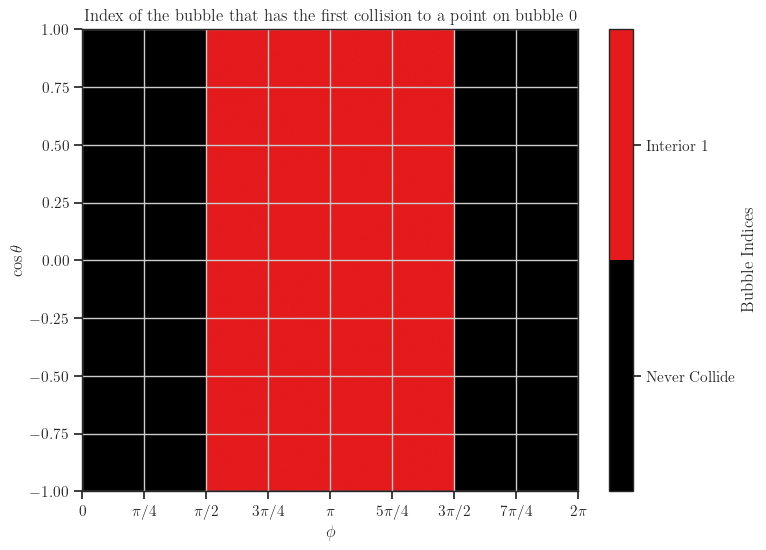

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bubble_collision.plot_first_collision_indices(fig, ax)
ax.grid(True)
fig.savefig(
    f"./figures/two_bubbles/first_collision.png",
    bbox_inches="tight",
    facecolor="white",
)
fig

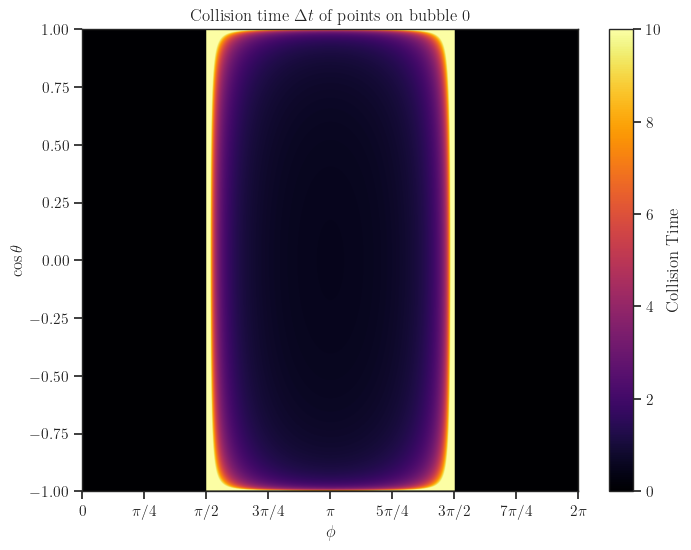

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bubble_collision.plot_collision_time(fig, ax, vmax=10)
fig.savefig(
    f"./figures/two_bubbles/collision_time.png", bbox_inches="tight", facecolor="white"
)
fig

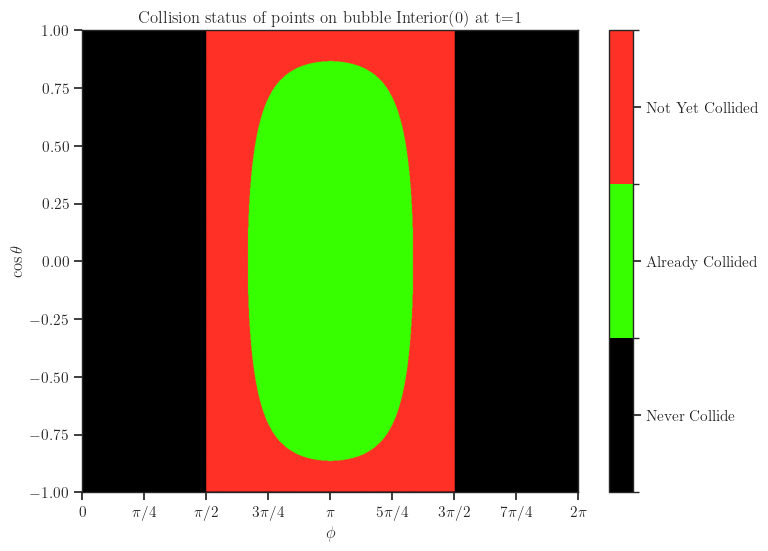

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bubble_collision.plot_collision_status(
    fig, ax, t=1, colors=["#000000", "#37ff00", "#ff3025"]
)
fig.savefig(
    f"./figures/two_bubbles/collision_status.png",
    bbox_inches="tight",
    facecolor="white",
)
fig

In [10]:
n_t = 1000
t_end = 0.8 * d
bulk_flow.set_resolution(1000, 1000)
bulk_flow.set_gradient_scaling_params(
    coefficients_sets=[
        [0.0],  # Envelope approximation
        [1.0],
        [1.0],
        [1.0],
        [1.0],
        [1.0],
    ],
    powers_sets=[
        [3.0],
        [3.0],  # Konstandin Bulk-flow approximation
        [5.0],
        [7.0],
        [9.0],
        [11.0],
    ],
)
w_arr = np.geomspace(1e-2, 1e3, 200)
C_arr = bulk_flow.compute_c_integral(w_arr=w_arr, t_begin=0.0, t_end=t_end, n_t=n_t)

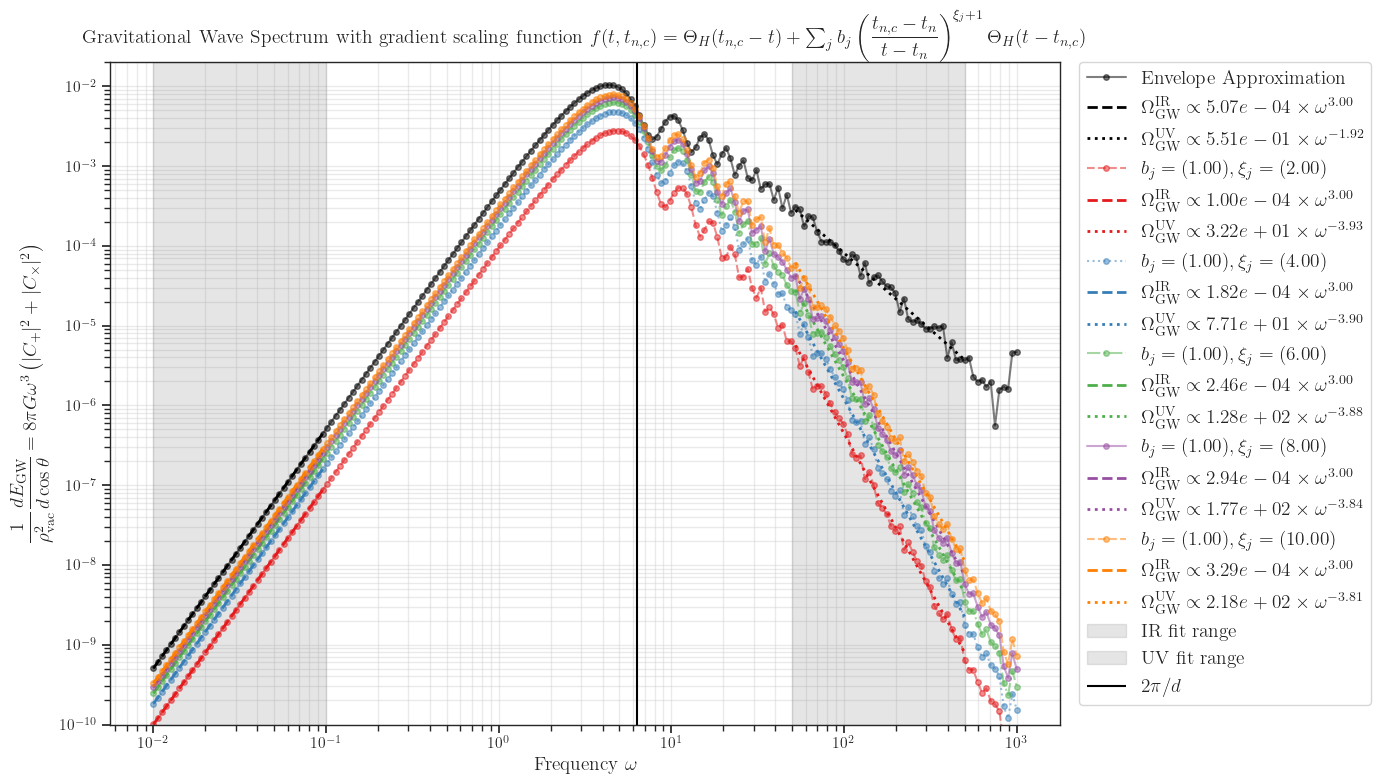

In [11]:
# 500, 500
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
fig, ax = plot_omega_gw(
    fig,
    ax,
    w_arr=w_arr,
    C_arr=C_arr,
    ir_range=(1e-2, 1e-1),
    uv_range=(5e1, 5e2),
    coefficients_sets=bulk_flow.coefficients_sets,
    powers_sets=bulk_flow.powers_sets,
    colormap="Set1",
)
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(numticks=999, subs="auto"))
ybottom, ytop = (1e-10, 2e-2)
ax.set_ylim(bottom=ybottom, top=ytop)
ax.vlines(x=2 * np.pi / d, ymin=ybottom, ymax=ytop, color="black", label=r"$2 \pi / d$")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0, fontsize=14)
fig.savefig(
    f"./figures/two_bubbles/gw_spectrum_apprx.png",
    bbox_inches="tight",
    facecolor="white",
)
fig

## Many bubbles

In [12]:
L = 2.0
bubbles_interior = np.loadtxt("./inputs/confY.txt")
lattice = many_bubbles.Lattice.Cartesian(
    origin=[0.0, 0.0, 0.0], basis=[[L, 0.0, 0.0], [0.0, L, 0.0], [0.0, 0.0, L]]
)

lattice_bubbles = many_bubbles.LatticeBubbles(
    bubbles_interior=bubbles_interior,
    lattice=lattice,
    sort_by_time=False,
)
lattice_bubbles.with_boundary_condition("periodic")
bulk_flow = many_bubbles.BulkFlow(lattice_bubbles)
bulk_flow.set_resolution(n_cos_thetax=1000, n_phix=1000, precompute_first_bubbles=True)

In [13]:
bubble_collision = BubbleCollision(bulk_flow=bulk_flow)
bubble_collision.set_reference_bubble_index(a_idx=0)  # Set the reference bubble index

In [14]:
# Get collision info for a specific point on the reference bubble
info = bubble_collision.get_collision_info(phi=0.0, cos_theta=0.75)
print(f"(phi, cos(theta)) = ({info['phi']:.3f}, {info['cos_theta']:.3f})")
if (first_bubble_index := info["first_bubble_index"]) > 0:
    print(f"Index of first bubble in collision = Interior({first_bubble_index})")
else:
    print(f"Index of first bubble in collision = Exterior({-first_bubble_index - 2})")
print(f"Collision time = {info['collision_time']}")

(phi, cos(theta)) = (0.000, 0.750)
Index of first bubble in collision = Interior(2)
Collision time = 0.42062401035649466


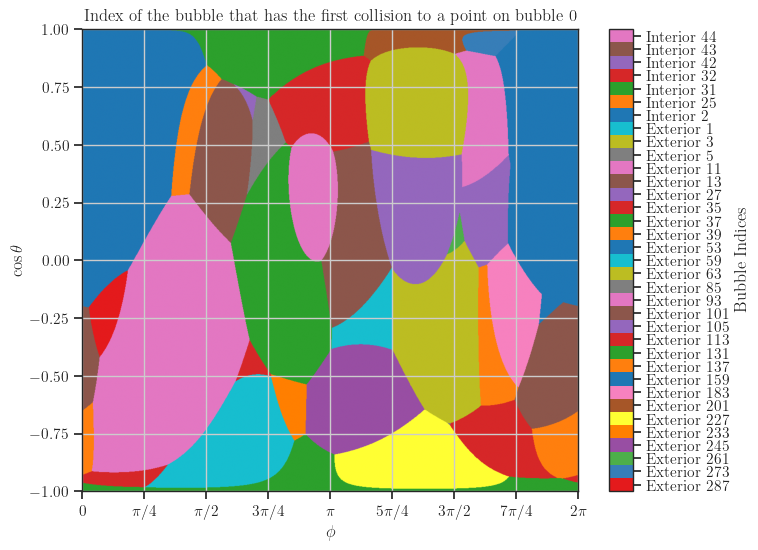

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bubble_collision.plot_first_collision_indices(fig, ax)
ax.grid(True)
fig.savefig(
    f"./figures/many_bubbles/first_collision.png",
    bbox_inches="tight",
    facecolor="white",
)
fig

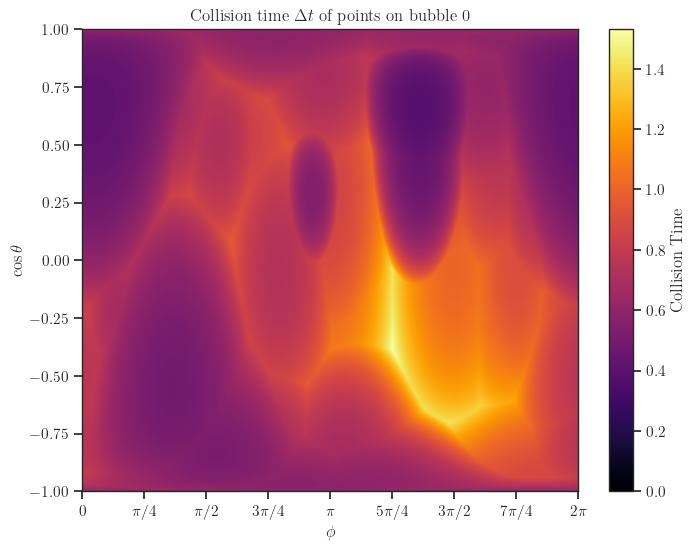

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bubble_collision.plot_collision_time(fig, ax)
fig.savefig(
    f"./figures/many_bubbles/collision_time.png", bbox_inches="tight", facecolor="white"
)
fig

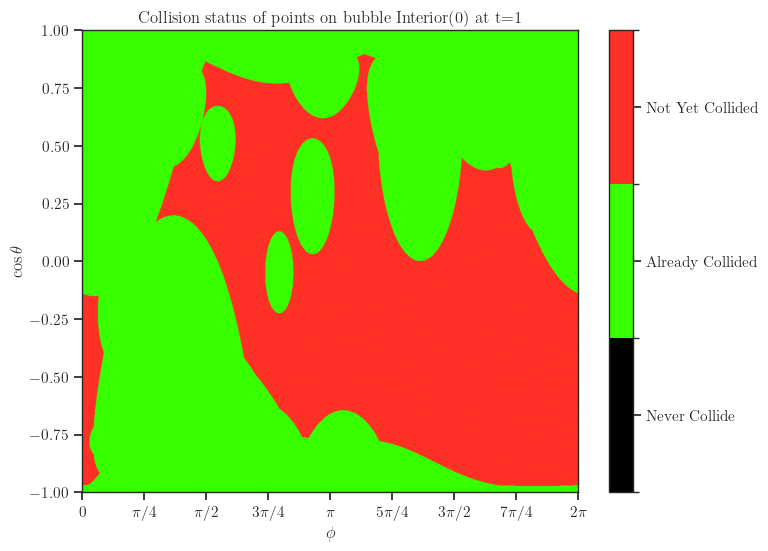

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bubble_collision.plot_collision_status(
    fig, ax, t=1, colors=["#000000", "#37ff00", "#ff3025"]
)
fig.savefig(
    f"./figures/many_bubbles/collision_status.png",
    bbox_inches="tight",
    facecolor="white",
)
fig